In [ ]:
#install kaggle
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"aniketpal0001","key":"cedbce2bb16967f0be583aafac73a563"}'}

In [ ]:
#create a kaggle folder
! mkdir ~/.kaggle

In [ ]:
#copy the kaggle.json to the kaggle directory
! cp kaggle.json ~/.kaggle/

In [ ]:
#permission for the json in kaggle

! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d abhikjha/utk-face-cropped

 97% 225M/232M [00:04<00:00, 42.8MB/s]
100% 232M/232M [00:05<00:00, 48.6MB/s]


In [ ]:
import zipfile
zip = zipfile.ZipFile('/content/utk-face-cropped.zip','r')
zip.extractall('/content')
zip.close()

In [ ]:
import os
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
folder_path = '/content/utkcropped/utkcropped'

In [ ]:
age =[]
gender =[]
image_path =[]
for file in os.listdir(folder_path):
  age.append(int(file.split('_')[0]))
  gender.append(int(file.split('_')[1]))
  image_path.append(file)

In [ ]:
len(age)


23709

In [ ]:
df = pd.DataFrame({'age':age,'gender':gender,'image':image_path})

In [ ]:
# male - 0 female -1

In [ ]:
df.head()

,age,gender,image
0,36,1,36_1_0_20170116165722892.jpg.chip.jpg
1,36,0,36_0_4_20170113133645566.jpg.chip.jpg
2,34,0,34_0_3_20170119200758796.jpg.chip.jpg
3,53,1,53_1_0_20170104184217989.jpg.chip.jpg
4,1,0,1_0_3_20161219225633088.jpg.chip.jpg


In [ ]:
df.shape

(23709, 3)

In [ ]:
train_df = df.sample(frac=1,random_state=0).iloc[:20000]
test_df = df.sample(frac=1,random_state=0).iloc[20000:]

In [ ]:
train_df.shape

(20000, 3)

In [ ]:
test_df.shape

(3709, 3)

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=30,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_dataframe(train_df,
                                                    directory=folder_path,
                                                    x_col='image',
                                                    y_col=['age','gender'],
                                                    target_size=(200,200),
                                                    class_mode='multi_output')

test_generator = test_datagen.flow_from_dataframe(test_df,
                                                    directory=folder_path,
                                                    x_col='image',
                                                    y_col=['age','gender'],
                                                    target_size=(200,200),
                                                  class_mode='multi_output')

Found 20000 validated image filenames.
Found 3709 validated image filenames.


In [ ]:
from keras.applications.resnet50 import ResNet50
from keras.layers import *
from keras.models import Model

In [ ]:
resnet = ResNet50(include_top=False, input_shape=(200,200,3))

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
resnet = ResNet50(include_top=False, input_shape=(200,200,3))

resnet.trainable=False

output = resnet.layers[-1].output

flatten = Flatten()(output)

dense1 = Dense(512, activation='relu')(flatten)
dense2 = Dense(512,activation='relu')(flatten)

dense3 = Dense(512,activation='relu')(dense1)

dense4 = Dense(512,activation='relu')(dense2)

dense5 = Dense(1024,activation = 'relu')(dense3)

dense6 = Dense(1024,activation = 'relu')(dense4)

output1 = Dense(1,activation='linear',name='age')(dense5)
output2 = Dense(1,activation='sigmoid',name='gender')(dense6)

In [ ]:
model = Model(inputs=resnet.input,outputs=[output1,output2])

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 200, 200, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 206, 206, 3)          0         ['input_4[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 100, 100, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 100, 100, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [ ]:
from keras.utils import plot_model

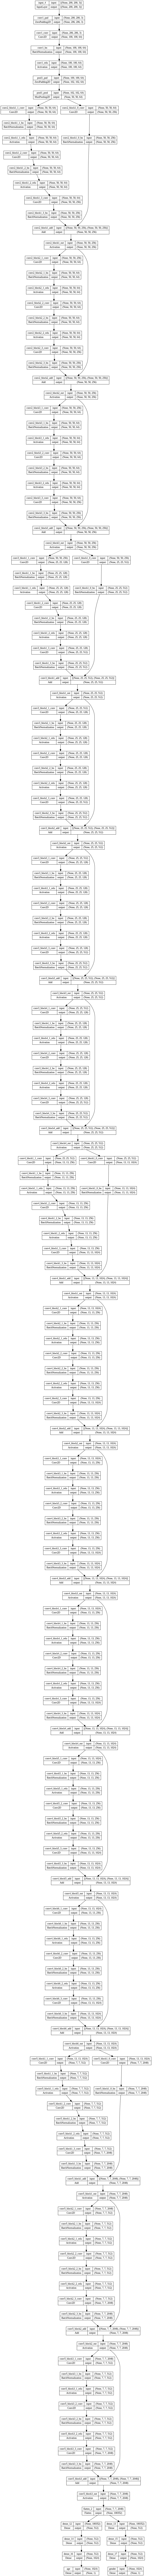

In [ ]:
plot_model(model, show_shapes= True)

In [ ]:
model.compile(optimizer='adam',
              loss={'age': 'mae', 'gender': 'binary_crossentropy'},
              metrics={'age': 'mae', 'gender': 'accuracy'},
              loss_weights={'age':1,'gender':99})

In [ ]:
history = model.fit(train_generator, batch_size=32, epochs=10, validation_data=test_generator)

Epoch 1/10
625/625 [==============================] - 248s 377ms/step - loss: 94.0471 - age_loss: 15.2647 - gender_loss: 0.7958 - age_mae: 15.2647 - gender_accuracy: 0.5163 - val_loss: 84.5200 - val_age_loss: 16.0368 - val_gender_loss: 0.6917 - val_age_mae: 16.0368 - val_gender_accuracy: 0.5282
Epoch 2/10
625/625 [==============================] - 235s 376ms/step - loss: 84.4384 - age_loss: 15.0066 - gender_loss: 0.7013 - age_mae: 15.0066 - gender_accuracy: 0.5217 - val_loss: 83.6478 - val_age_loss: 15.1625 - val_gender_loss: 0.6918 - val_age_mae: 15.1625 - val_gender_accuracy: 0.5282
Epoch 3/10
625/625 [==============================] - 242s 387ms/step - loss: 83.4266 - age_loss: 14.8229 - gender_loss: 0.6930 - age_mae: 14.8229 - gender_accuracy: 0.5217 - val_loss: 83.4847 - val_age_loss: 15.0149 - val_gender_loss: 0.6916 - val_age_mae: 15.0149 - val_gender_accuracy: 0.5282
Epoch 4/10
625/625 [==============================] - 231s 369ms/step - loss: 83.6958 - age_loss: 14.7908 - gend

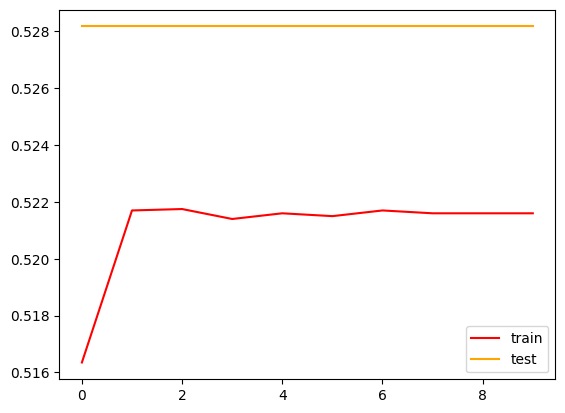

In [ ]:
plt.plot(history.history['gender_accuracy'],color = 'red',label = 'train')
plt.plot(history.history['val_gender_accuracy'],color = 'orange',label = 'test')
plt.legend()
plt.show()


In [ ]:
plt.plot(history.history['gender_accuracy'],color = 'red',label = 'train')
plt.plot(history.history['val_gender_accuracy'],color = 'orange',label = 'test')
plt.legend()
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
img_path = '/content/drive/MyDrive/face images/12021002022029.jpg'

In [ ]:
import matplotlib.pyplot as plt
import cv2

In [ ]:
test_img = cv2.imread(img_path)

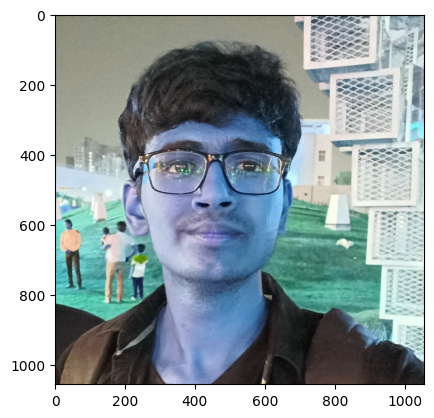

In [ ]:
plt.imshow(test_img)

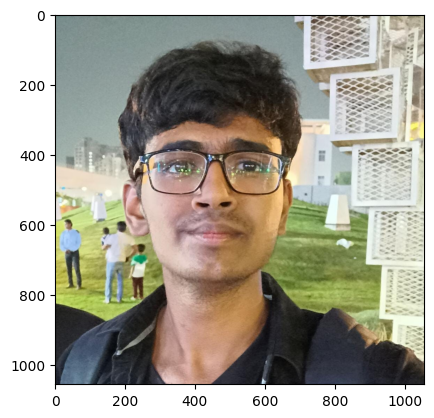

In [ ]:
# prompt: read the test_img as RGB with cv2 and show it

test_img = cv2.imread(img_path)
plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))


In [ ]:
test_img.shape

(1057, 1057, 3)

In [ ]:
test_img = cv2.resize(test_img, (200, 200))

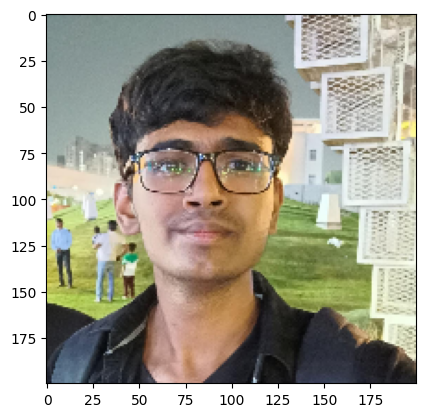

In [ ]:
plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))

In [ ]:
test_img.shape

(200, 200, 3)

In [ ]:
test_input = test_img.reshape((1,200,200,3))

In [ ]:
# prompt: print the prediction of the model as interger dtype

predictions = model.predict(test_input)
print(np.array(predictions).astype(int))

1/1 [==============================] - 0s 44ms/step
[[[49]]

 [[ 0]]]


In [ ]:
print(np.argmax(predictions))

In [ ]:
model.predict(test_input)

1/1 [==============================] - 2s 2s/step


[array([[49.21305]], dtype=float32), array([[0.6635806]], dtype=float32)]

In [ ]:
img_path_1 = '/content/drive/MyDrive/face images/Screenshot 2024-01-15 232853.png'

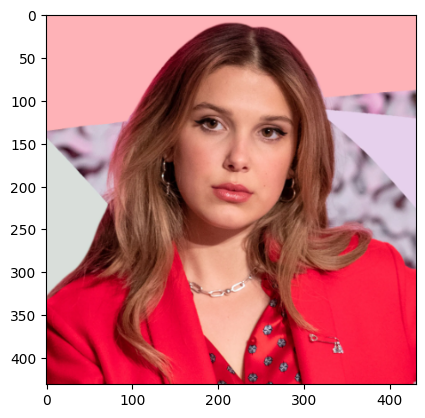

In [ ]:
test_img_1 = cv2.imread(img_path_1)
plt.imshow(cv2.cvtColor(test_img_1, cv2.COLOR_BGR2RGB))

In [ ]:
test_img_1.shape

(431, 431, 3)

In [ ]:
test_img_1 = cv2.resize(test_img_1, (200, 200))

In [ ]:
test_input_1 = test_img_1.reshape((1,200,200,3))

In [ ]:
test_input_1.shape

(1, 200, 200, 3)

In [ ]:
# prompt: print the prediction of the model as interger dtype

predictions = model.predict(test_input_1)
print(np.array(predictions).astype(int))

1/1 [==============================] - 0s 23ms/step
[[[74]]

 [[ 0]]]
